In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io as sio
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, SGD, Adadelta, RMSprop, Nadam

from sklearn import metrics, preprocessing

from Utils import zeroPadding, normalization, doPCA, modelStatsRecord, averageAccuracy, ssrn_SS_UP

print('Finished importing modules in *UP classification maps* at ' + time.ctime(time.time()))

Using TensorFlow backend.


Finished importing modules in *UP classification maps* at Fri May  3 01:46:48 2019


In [3]:
def sampling(proptionVal, groundTruth):              #divide dataset into train and test datasets
    labels_loc = {}
    train = {}
    test = {}
    m = max(groundTruth)
    for i in range(m):
        indices = [j for j, x in enumerate(groundTruth.ravel().tolist()) if x == i + 1]
        np.random.shuffle(indices)
        labels_loc[i] = indices
        nb_val = int(proptionVal * len(indices))
        train[i] = indices[:-nb_val]
        test[i] = indices[-nb_val:]
#    whole_indices = []
    train_indices = []
    test_indices = []
    for i in range(m):
#        whole_indices += labels_loc[i]
        train_indices += train[i]
        test_indices += test[i]
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)
    return train_indices, test_indices

print('Finished importing modules in *UP classification maps* at ' + time.ctime(time.time()))

Finished importing modules in *UP classification maps* at Fri May  3 01:46:51 2019


In [4]:
def indexToAssignment(index_, Row, Col, pad_length):
    new_assign = {}
    for counter, value in enumerate(index_):
        assign_0 = value // Col + pad_length
        assign_1 = value % Col + pad_length
        new_assign[counter] = [assign_0, assign_1]
    return new_assign

print('Finished importing indexToAssignment modules in *UP classification maps* at ' + time.ctime(time.time()))

Finished importing indexToAssignment modules in *UP classification maps* at Fri May  3 01:46:52 2019


In [5]:
def assignmentToIndex( assign_0, assign_1, Row, Col):
    new_index = assign_0 * Col + assign_1
    return new_index

print('Finished importing Assignment to Index module in *UP classification maps* at ' + time.ctime(time.time()))

Finished importing Assignment to Index module in *UP classification maps* at Fri May  3 01:46:56 2019


In [6]:
def selectNeighboringPatch(matrix, pos_row, pos_col, ex_len):
    selected_rows = matrix[range(pos_row-ex_len,pos_row+ex_len+1), :]
    selected_patch = selected_rows[:, range(pos_col-ex_len, pos_col+ex_len+1)]
    return selected_patch

print('Finished importing selectNeighboringPatch module in *UP classification maps* at ' + time.ctime(time.time()))

Finished importing selectNeighboringPatch module in *UP classification maps* at Fri May  3 01:46:57 2019


In [11]:
def classification_map(map, groundTruth, dpi, savePath):

    fig = plt.figure(frameon=False)
    fig.set_size_inches(groundTruth.shape[1]*2.0/dpi, groundTruth.shape[0]*2.0/dpi)

    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)

    ax.imshow(map)
    fig.savefig(savePath, dpi = dpi)

    return 0

print('Finished importing classificationMap module in *UP classification maps* at ' + time.ctime(time.time()))

Finished importing classificationMap module in *UP classification maps* at Fri May  3 02:16:04 2019


In [8]:
def res4_model_ss():
    model_res4 = ssrn_SS_UP.ResnetBuilder.build_resnet_8((1, img_rows, img_cols, img_channels), nb_classes)

    RMS = RMSprop(lr=0.0003)
    # Let's train the model using RMSprop
    model_res4.compile(loss='categorical_crossentropy', optimizer=RMS, metrics=['accuracy'])

    return model_res4

print('Finished importing res4 model ss in *UP classification maps* at ' + time.ctime(time.time()))

Finished importing res4 model ss in *UP classification maps* at Fri May  3 01:46:58 2019


(610, 340, 103)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint16 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


# 1 Iteration
input shape: 103
input shape: (None, 7, 7, 49, 24)
conv_spc_result shape: (None, 7, 7, 1, 128)
conv1 shape: (None, 5, 5, 1, 24)
input shape: (None, 5, 5, 1, 24)


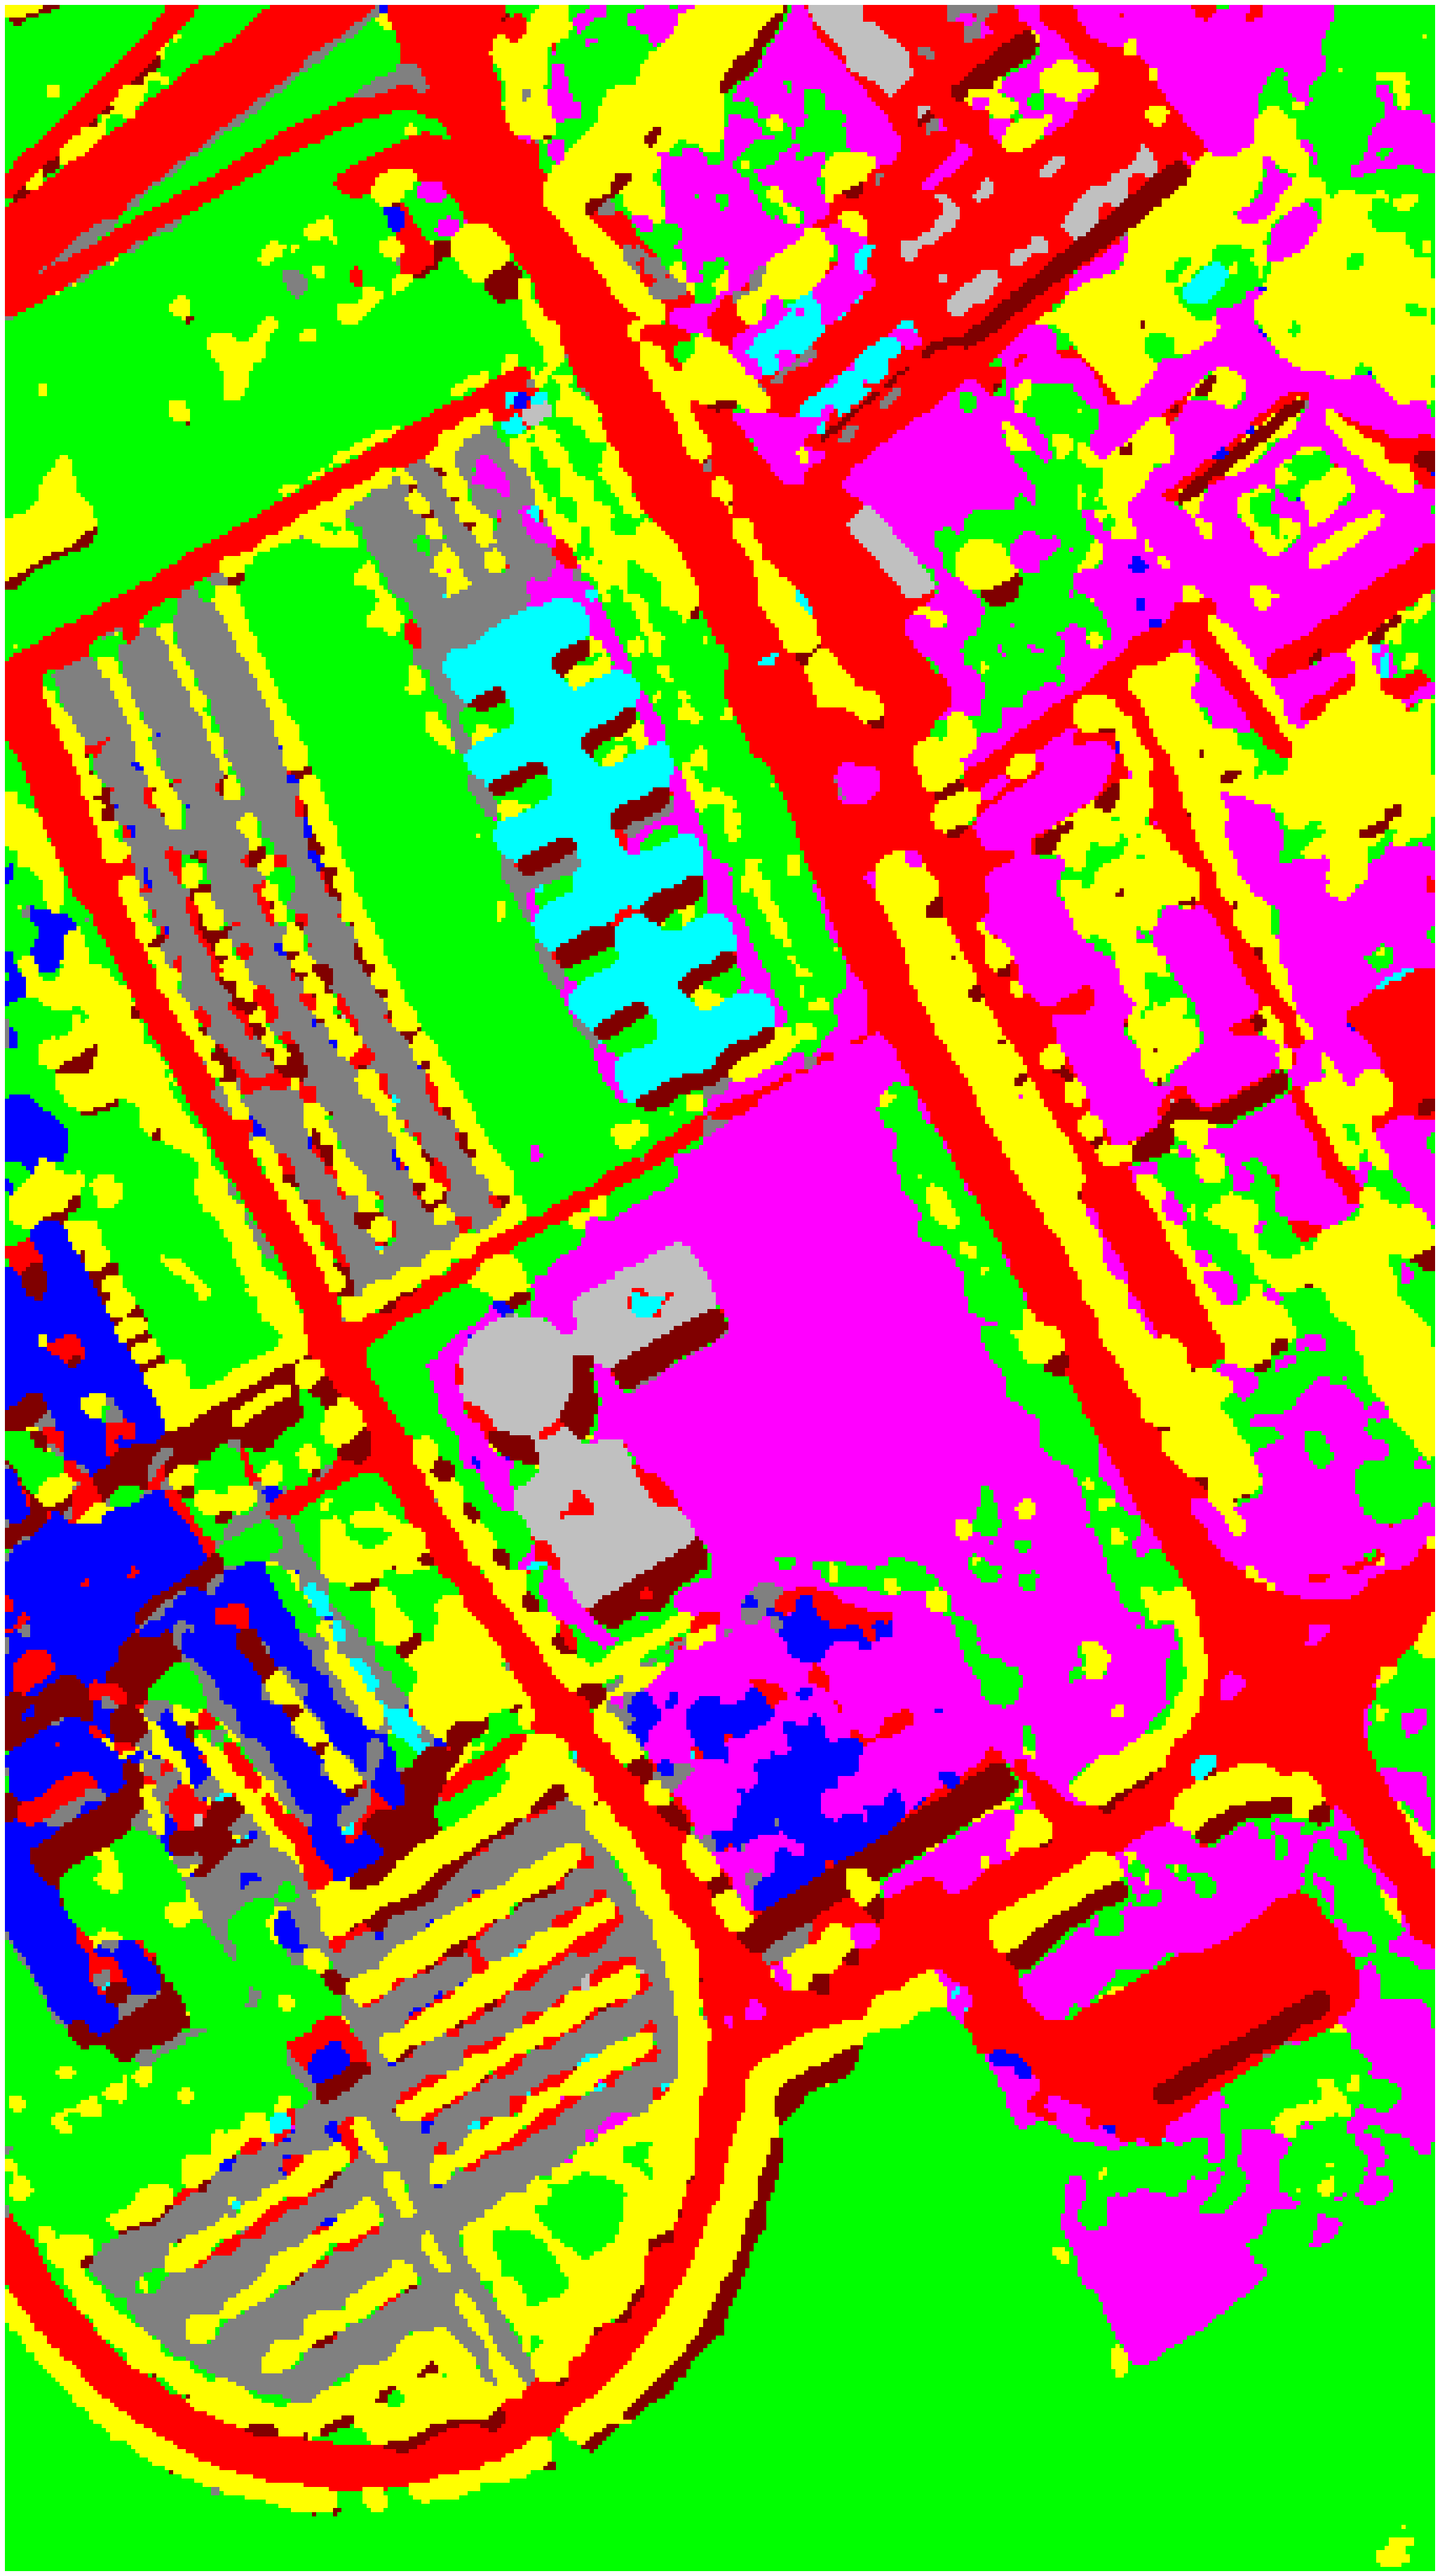

In [13]:
uPavia = sio.loadmat(r'''C:/Users/josep/Desktop/RS/residualnet_tensorflow_keras/residualnet_tensorflow_keras/SSRN-master//datasets/UP/PaviaU.mat''')
gt_uPavia = sio.loadmat(r'''C:/Users/josep/Desktop/RS/residualnet_tensorflow_keras/residualnet_tensorflow_keras/SSRN-master/datasets/UP/PaviaU_gt.mat''')
data_IN = uPavia['paviaU']
gt_IN = gt_uPavia['paviaU_gt']
print (data_IN.shape)

new_gt_IN = gt_IN

batch_size = 16
nb_classes = 9
nb_epoch = 200   #400
img_rows, img_cols = 7, 7         #27, 27
patience = 200

INPUT_DIMENSION_CONV = 103
INPUT_DIMENSION = 103

# 10%:10%:80% data for training, validation and testing

TOTAL_SIZE = 42776
VAL_SIZE = 4281
TRAIN_SIZE = 4281
TEST_SIZE = TOTAL_SIZE - TRAIN_SIZE

ALL_SIZE = data_IN.shape[0] * data_IN.shape[1]

img_channels = 103
VALIDATION_SPLIT = 0.90
PATCH_LENGTH = 3                 #Patch_size (13*2+1)*(13*2+1)

data = data_IN.reshape(np.prod(data_IN.shape[:2]),np.prod(data_IN.shape[2:]))
gt = new_gt_IN.reshape(np.prod(new_gt_IN.shape[:2]),)

data = preprocessing.scale(data)

# scaler = preprocessing.MaxAbsScaler()
# data = scaler.fit_transform(data)

data_ = data.reshape(data_IN.shape[0], data_IN.shape[1],data_IN.shape[2])
whole_data = data_
padded_data = zeroPadding.zeroPadding_3D(whole_data, PATCH_LENGTH)

# data_trans_AE = data.transpose()
# data_pca1_AE = doPCA.dimension_PCA(data_trans_AE, data_, 1)
# data_pca1_AE = data_pca1_AE.reshape(data_pca1_AE.shape[0], data_pca1_AE.shape[1])
# padded_pca1_AE = zeroPadding.zeroPadding_2D(data_pca1_AE, PATCH_LENGTH)

ITER = 1
CATEGORY = 9

all_data = np.zeros((ALL_SIZE, 2*PATCH_LENGTH + 1, 2*PATCH_LENGTH + 1, INPUT_DIMENSION_CONV))
train_data = np.zeros((TRAIN_SIZE, 2*PATCH_LENGTH + 1, 2*PATCH_LENGTH + 1, INPUT_DIMENSION_CONV))
test_data = np.zeros((TEST_SIZE, 2*PATCH_LENGTH + 1, 2*PATCH_LENGTH + 1, INPUT_DIMENSION_CONV))

x_all = all_data.reshape(all_data.shape[0], all_data.shape[1], all_data.shape[2],INPUT_DIMENSION_CONV)
x_train = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2],INPUT_DIMENSION_CONV)
x_test_all = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], INPUT_DIMENSION_CONV)

#seeds = [1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229]

seeds = [1334]

for index_iter in range(ITER):
    print("# %d Iteration" % (index_iter + 1))

    best_weights_RES_path_ss4 = r'''C:/Users/josep/Desktop/RS/residualnet_tensorflow_keras/residualnet_tensorflow_keras/SSRN-master/models/UP_best_RES_3D_SS4_5_''' + str(index_iter + 1) + '.hdf5'

    np.random.seed(seeds[0])

    #    train_indices, test_indices = sampleFixNum.samplingFixedNum(TRAIN_NUM, gt)
    train_indices, test_indices = sampling(VALIDATION_SPLIT, gt)

    y_train_raw = gt[train_indices] - 1
    y_train = to_categorical(np.asarray(y_train_raw))

    y_test_raw = gt[test_indices] - 1
    y_test = to_categorical(np.asarray(y_test_raw))

    all_assign = indexToAssignment(range(ALL_SIZE), whole_data.shape[0], whole_data.shape[1], PATCH_LENGTH)
    for i in range(len(all_assign)):
        all_data[i] = selectNeighboringPatch(padded_data, all_assign[i][0], all_assign[i][1], PATCH_LENGTH)

    # first principal component training data
    train_assign = indexToAssignment(train_indices, whole_data.shape[0], whole_data.shape[1], PATCH_LENGTH)
    # train_data = np.zeros((len(train_assign), 2*PATCH_LENGTH + 1, 2*PATCH_LENGTH + 1, INPUT_DIMENSION_CONV))
    for i in range(len(train_assign)):
        train_data[i] = selectNeighboringPatch(padded_data, train_assign[i][0], train_assign[i][1], PATCH_LENGTH)

    # first principal component testing data
    test_assign = indexToAssignment(test_indices, whole_data.shape[0], whole_data.shape[1], PATCH_LENGTH)
    # test_data = np.zeros((len(test_assign), 2*PATCH_LENGTH + 1, 2*PATCH_LENGTH + 1, INPUT_DIMENSION_CONV))
    for i in range(len(test_assign)):
        test_data[i] = selectNeighboringPatch(padded_data, test_assign[i][0], test_assign[i][1], PATCH_LENGTH)

    # x_train = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2], INPUT_DIMENSION_CONV)
    # x_test = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], INPUT_DIMENSION_CONV)

    # x_all = all_data.reshape(all_data.shape[0], all_data.shape[1], all_data.shape[2], INPUT_DIMENSION_CONV)
    # x_train = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2], INPUT_DIMENSION_CONV)
    # x_test_all = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], INPUT_DIMENSION_CONV)
    #
    # x_val = x_test_all[-VAL_SIZE:]
    # y_val = y_test[-VAL_SIZE:]
    #
    # x_test = x_test_all[:-VAL_SIZE]
    # y_test = y_test[:-VAL_SIZE]

# load trained model
    model_res4_ss = res4_model_ss()

    model_res4_ss.load_weights(best_weights_RES_path_ss4)

    pred_test_conv1 = model_res4_ss.predict(all_data.reshape(all_data.shape[0],all_data.shape[1],all_data.shape[2],all_data.shape[3],1)).argmax(axis=1)

    x = np.ravel(pred_test_conv1)
    # print x
    y = np.zeros((x.shape[0], 3))

    for index, item in enumerate(x):
        if item == 0:
            y[index] = np.array([255, 0, 0]) / 255.
        if item == 1:
            y[index] = np.array([0, 255, 0]) / 255.
        if item == 2:
            y[index] = np.array([0, 0, 255]) / 255.
        if item == 3:
            y[index] = np.array([255, 255, 0]) / 255.
        if item == 4:
            y[index] = np.array([0, 255, 255]) / 255.
        if item == 5:
            y[index] = np.array([255, 0, 255]) / 255.
        if item == 6:
            y[index] = np.array([192, 192, 192]) / 255.
        if item == 7:
            y[index] = np.array([128, 128, 128]) / 255.
        if item == 8:
            y[index] = np.array([128, 0, 0]) / 255.

    # print y

    y_re = np.reshape(y, (gt_IN.shape[0], gt_IN.shape[1], 3))

    classification_map(y_re, gt_IN, 24, r'''C:/Users/josep/Desktop/RS/residualnet_tensorflow_keras/residualnet_tensorflow_keras/SSRN-master/Cmaps/RES4_SS_UP.png''')

